In [2]:
# read in wrf auxout & lasso files
# compare large scale forcing

# perform area average on wrf 3-km outputs
# in order to match lasso 16-km outputs

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime

# c1 site location
site_latitude  = 36.6050
site_longitude = -97.485

# interpolate wrf variables to this height
# also a specified height in lasso data
target_height_agl = 80

# omit number of cells on edges
cut_cells = 10

obs_dir = '/projects/mmc/jlee/sgp/sgp_obs/'
wrf_runs_dir = '/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'
nb_dir = !pwd
# plots_dir = nb_dir[0]+'/plots_04c'

# obs
co2flx25m_ncs = obs_dir+'sgpco2flx25mC1.b1/*.nc'
# obs bowen_ratio is nan...!

co2flx25m = xr.open_mfdataset(co2flx25m_ncs)

# plotting variables
co2flx25m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)']}

co2flx4m_ncs = obs_dir+'sgpco2flx4mC1.b1/*.nc'
co2flx4m = xr.open_mfdataset(co2flx4m_ncs)
co2flx4m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ebbre13_ncs = obs_dir+'sgp30ebbrE13.b1/*.nc'
ebbre13 = xr.open_mfdataset(ebbre13_ncs)
ebbre13_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', r'latent heat flux (W m$^{-2}$)']}

ecore14_ncs = obs_dir+'sgp30ecorE14.b1/*.cdf'
ecore14 = xr.open_mfdataset(ecore14_ncs)
ecore14_dict = {'hfx': ['h', r'sensible heat flux (W m$^{-2}$)'], 
                'lh': ['lv_e', r'latent heat flux (W m$^{-2}$)']}

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

runs_list = list(data_dir_df.index)[:-1]

In [142]:
runs_list

['mynn',
 'mynn_ck0.1',
 'edmf',
 'mynn_all4d-1arcs-topo',
 'mynn_d12-9s_d34-1s',
 'mynn_d123-9s_d4-1s_lu',
 'mynn_all4d-9arcs_lu',
 'edmf_d12-9s_d34-1s']

In [5]:
def plot_area_flux_ts(eval_date, run):

    dpath = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'+data_dir_df[eval_date][run]+'/auxout/'

    df = pd.DataFrame()

    for file in glob.glob(dpath+'mmc_d04*'):

        if '_15:00' not in file: 

            wrf_single = Dataset(file, 'r')

            site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

            wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

            hfx = wrf.getvar(wrf_single, 'HFX', timeidx=wrf.ALL_TIMES)
            lh = wrf.getvar(wrf_single, 'LH', timeidx=wrf.ALL_TIMES)

            if wrf_time.shape[0] > 1:

                hfx_1pt = hfx[:, site_loc_ij.values[1], site_loc_ij.values[0]]
                lh_1pt = lh[:, site_loc_ij.values[1], site_loc_ij.values[0]]

                hfx_cut = hfx[:, cut_cells:-cut_cells, cut_cells:-cut_cells]
                lh_cut = lh[:, cut_cells:-cut_cells, cut_cells:-cut_cells]

                hfx_mean = hfx_cut.mean(dim=['south_north', 'west_east'])
                hfx_std = hfx_cut.std(dim=['south_north', 'west_east'])

                lh_mean = lh_cut.mean(dim=['south_north', 'west_east'])
                lh_std = lh_cut.std(dim=['south_north', 'west_east'])

            else: 

                hfx_1pt = hfx[site_loc_ij.values[1], site_loc_ij.values[0]].values
                lh_1pt = lh[site_loc_ij.values[1], site_loc_ij.values[0]].values

                hfx_cut = hfx[cut_cells:-cut_cells, cut_cells:-cut_cells]
                lh_cut = lh[cut_cells:-cut_cells, cut_cells:-cut_cells]

                hfx_mean = hfx_cut.mean(dim=['south_north', 'west_east']).values
                hfx_std = hfx_cut.std(dim=['south_north', 'west_east']).values

                lh_mean = lh_cut.mean(dim=['south_north', 'west_east']).values
                lh_std = lh_cut.std(dim=['south_north', 'west_east']).values

            df_1file = pd.DataFrame(index=wrf_time, 
                                    data={'hfx_mean': hfx_mean, 'hfx_std': hfx_std, 'hfx_1pt': hfx_1pt, 
                                          'lh_mean': lh_mean, 'lh_std': lh_std, 'lh_1pt': lh_1pt})

            df = df.append(df_1file)

            df.sort_index(inplace=True)

    co2flx25m_ds = co2flx25m.sel(time=slice(df.index.min(), eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(df.index.min(), eval_date))
    ebbre13_ds = ebbre13.sel(time=slice(df.index.min(), eval_date))
    ecore14_ds = ecore14.sel(time=slice(df.index.min(), eval_date))
            
    # resample wrf every 30 minute to match obs frequency
    # obs are 30-minute averages
    df = df.resample('30min').mean()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(df.index, df['hfx_mean'], label='wrf domain mean', c='k', linewidth=1.5)
    ax[0].plot(df.index, df['hfx_1pt'], label='wrf c1', c='k', linewidth=1, linestyle='--')
    ax[0].fill_between(df.index, df['hfx_mean']+df['hfx_std'], df['hfx_mean']-df['hfx_std'], color='k',
                       alpha=0.1, label='wrf mean + std')

    ax[1].plot(df.index, df['lh_mean'], label='wrf domain mean', c='k', linewidth=1.5)
    ax[1].plot(df.index, df['lh_1pt'], label='wrf c1', c='k', linewidth=1, linestyle='--')
    ax[1].fill_between(df.index, df['lh_mean']+df['lh_std'], df['lh_mean']-df['lh_std'], color='k',
                       alpha=0.1, label='wrf mean + std')
    
    ax[0].set_ylim(0, 440)
    ax[1].set_ylim(0, 440)

    # co2flx25m_ds

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        co2flx4m_ds[var[1][0]] = co2flx4m[var[1][0]].where(co2flx4m['qc_'+var[1][0]] <= 3)
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        ebbre13_ds[var[1][0]] = ebbre13[var[1][0]].where(ebbre13['qc_'+var[1][0]] == 0)
        ax_i.plot(ebbre13_ds['time'], -ebbre13_ds[var[1][0]], label='ebbre13')

    for var, ax_i in zip(ecore14_dict.items(), ax): 

        ecore14_ds[var[1][0]] = ecore14[var[1][0]].where(ecore14['qc_'+var[1][0]] == 0)
        ax_i.plot(ecore14_ds['time'], ecore14_ds[var[1][0]], label='ecore14')

    for wrf_var, var in co2flx25m_dict.items(): 

        co2flx25m_ds[var[0]] = co2flx25m[var[0]].where(co2flx25m['qc_'+var[0]] <= 3)
        ax[0].plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.set_title(var[1][0]+': '+run+'\n'+' vs obs: '+eval_date+'\nwrf mean std = '
                       +str(np.round(df[var[0]+'_std'].mean(), 3))+r' W m$^{-2}$')
        ax_i.set_ylabel(var[1][1])
    #     ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)

    #     ax_i.legend()
        handles, labels = ax_i.get_legend_handles_labels()
    #     print(labels)
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax_i.legend(handles, labels)

    ax[0].tick_params(labelrotation=90)
    ax[1].tick_params(labelrotation=90)
    
#     plt.savefig(plots_dir+'/'+eval_date+'_2areaflux_'+run+'.pdf')

    plt.show()

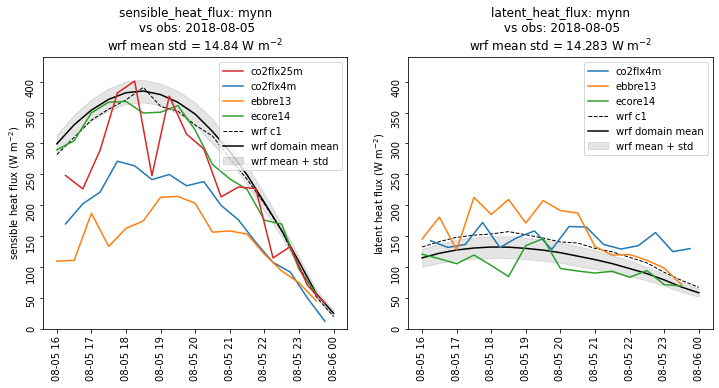

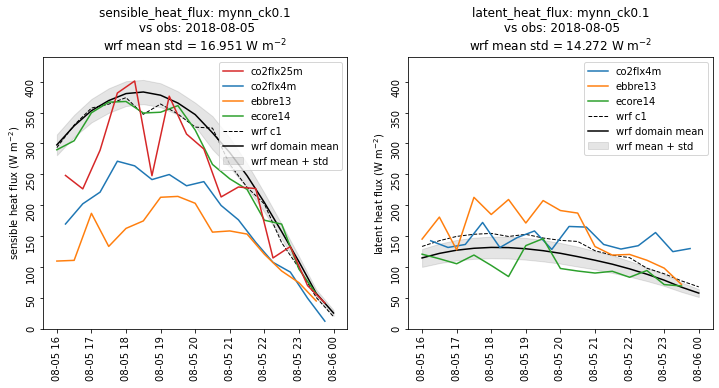

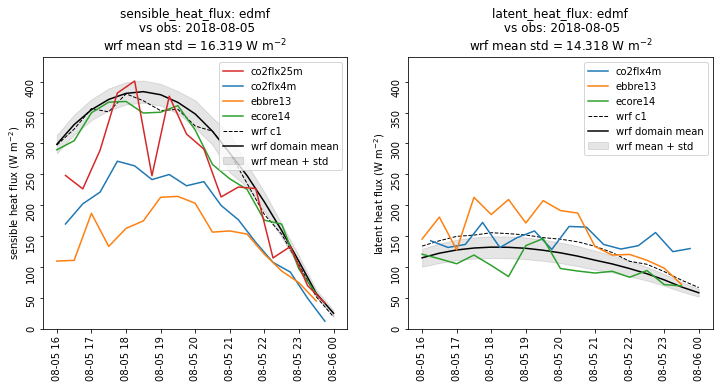

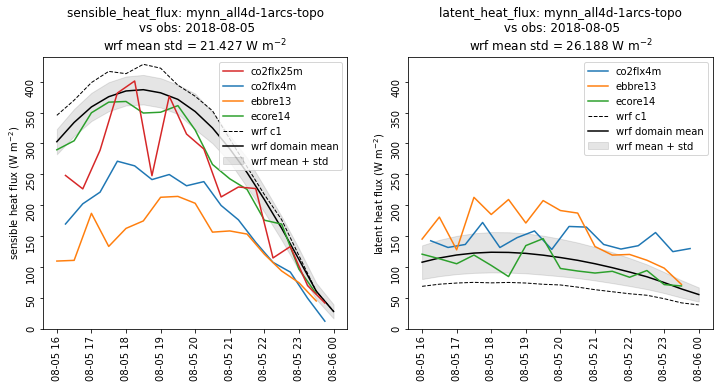

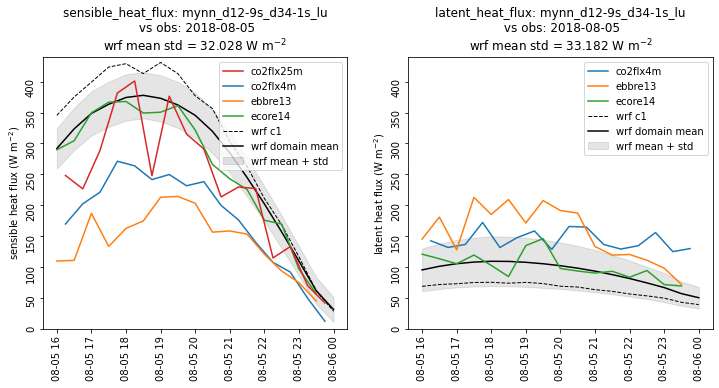

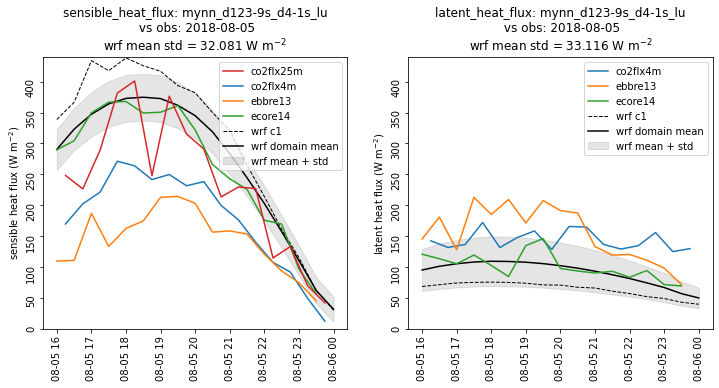

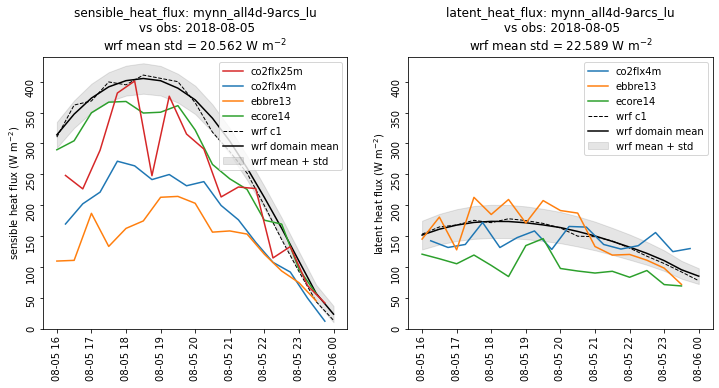

In [6]:
eval_date = '2018-08-05'

for run in runs_list: 
    plot_area_flux_ts(eval_date, run)

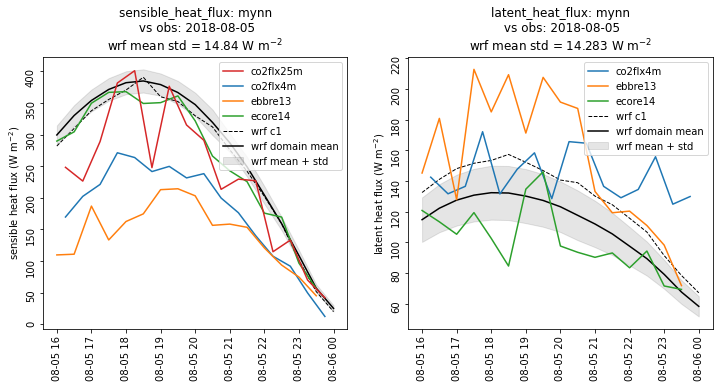

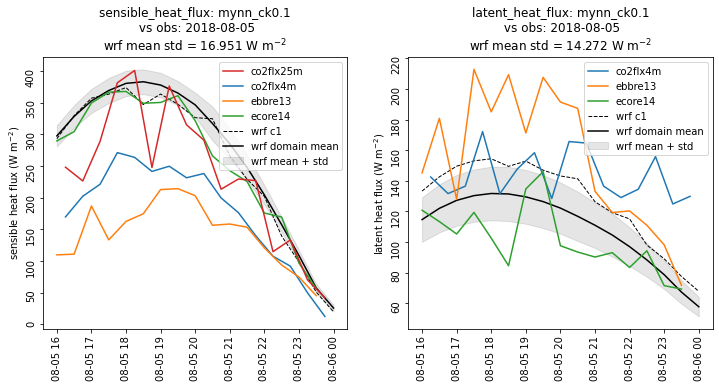

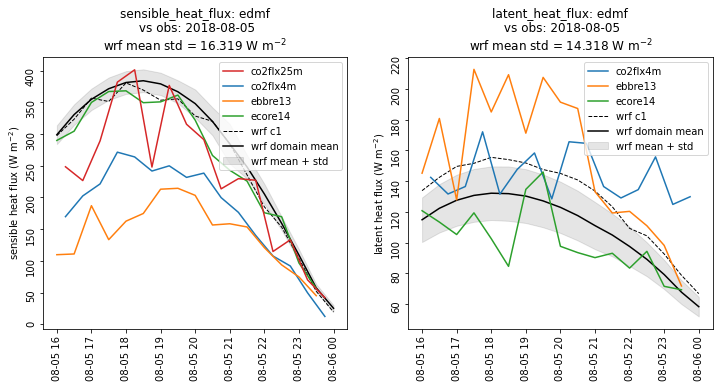

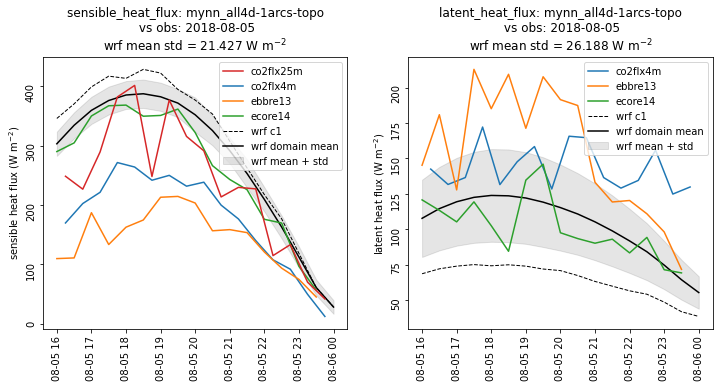

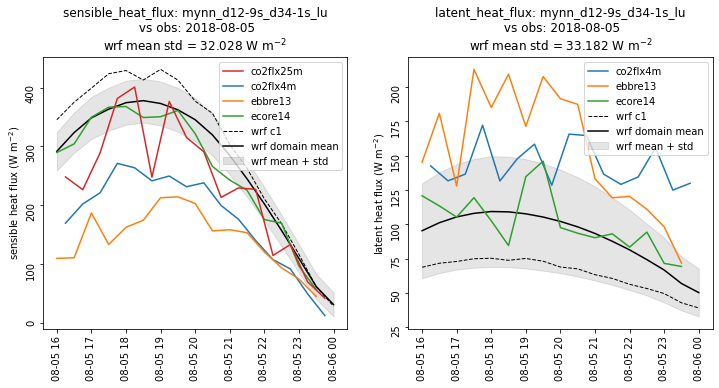

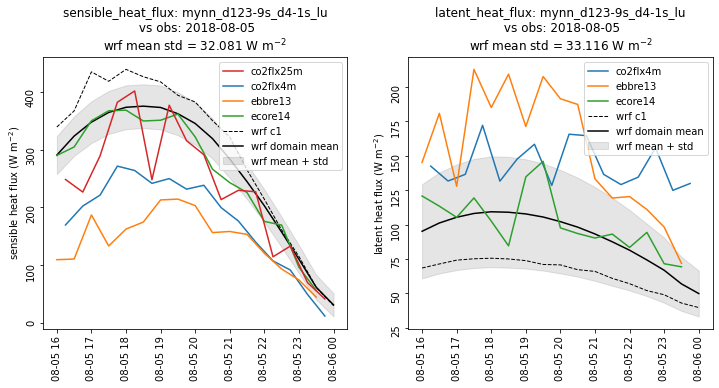

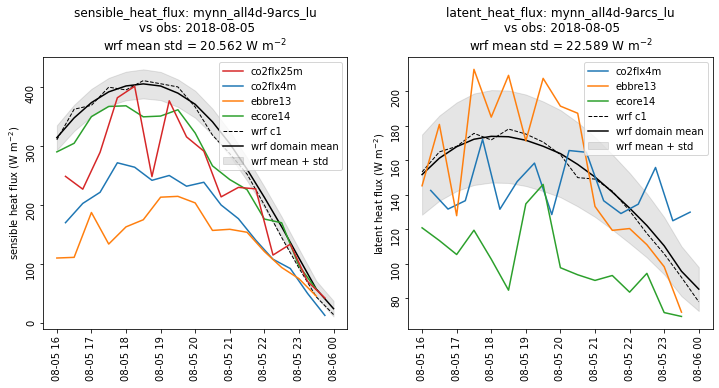

In [4]:
eval_date = '2018-08-05'

for run in runs_list: 
    plot_area_flux_ts(eval_date, run)

In [93]:
hfx_mean

<xarray.DataArray 'HFX' ()>
array(-3.2126684, dtype=float32)
Coordinates:
    XTIME    float32 2.16e+03
    Time     datetime64[ns] 2018-08-06

In [95]:
pd.DataFrame(index=wrf_time, data={'hfx_mean': hfx_mean.values})

,hfx_mean
2018-08-06,-3.212668


In [92]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-06,"<xarray.DataArray 'HFX' ()>\narray(-3.2126684,...","<xarray.DataArray 'HFX' ()>\narray(42.221954, ...","<xarray.DataArray 'HFX' ()>\narray(18.117317, ...","<xarray.DataArray 'LH' ()>\narray(96.41406, dt...","<xarray.DataArray 'LH' ()>\narray(49.86127, dt...","<xarray.DataArray 'LH' ()>\narray(63.869427, d..."


In [81]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-05 13:00:00,29.605160,22.549570,44.749924,43.471588,28.826183,30.410643
2018-08-05 13:10:00,44.461697,25.527706,62.171974,52.768864,31.974773,36.570839
2018-08-05 13:20:00,54.735039,28.111589,74.688362,60.397194,34.786995,41.509506
2018-08-05 13:30:00,65.421143,30.709684,87.408165,68.031631,37.745651,46.506176
2018-08-05 13:40:00,81.683609,33.922443,106.000969,77.547310,41.651836,52.736633
2018-08-05 13:50:00,92.809105,36.480629,119.025345,85.106354,44.904896,57.656109


In [75]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-05 12:00:00,-107.152649,81.830406,-115.687202,-103.330444,74.051262,-169.062881
2018-08-05 12:10:00,-13.580511,14.940534,-9.156095,11.320505,20.652605,8.248775
2018-08-05 12:20:00,-7.735733,15.406914,-2.185236,16.031279,21.458372,11.921228
2018-08-05 12:30:00,-0.743209,16.330603,6.809655,21.559875,22.626118,15.795577
2018-08-05 12:40:00,11.392712,18.272127,22.147596,29.574924,24.592218,20.914946
2018-08-05 12:50:00,20.186766,20.283964,33.286301,36.370480,26.595016,25.491013


In [55]:
hfx_mean.values

array([-107.15265   ,  -13.580511  ,   -7.735733  ,   -0.74320906,
         11.392712  ,   20.186766  ], dtype=float32)

In [53]:
df_1file

,hfx_mean,hfx_std,hfx_1pt,lh_mean,lh_std,lh_1pt
2018-08-05 12:00:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:10:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:20:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:30:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:40:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."
2018-08-05 12:50:00,[<xarray.DataArray 'HFX' ()>\narray(-107.15265...,"[<xarray.DataArray 'HFX' ()>\narray(81.83041, ...","[<xarray.DataArray 'HFX' ()>\narray(-115.6872,...",[<xarray.DataArray 'LH' ()>\narray(-103.330444...,"[<xarray.DataArray 'LH' ()>\narray(74.05126, d...","[<xarray.DataArray 'LH' ()>\narray(-169.06288,..."


In [43]:
hfx

<xarray.DataArray 'HFX' (Time: 6, south_north: 220, west_east: 220)>
array([[[-106.04029   , -163.18684   , -152.90123   , ...,
          -60.473877  ,  -22.071964  ,  -91.76922   ],
        [-200.57564   , -198.27393   , -128.31491   , ...,
          -96.801674  ,  -84.1741    ,  -59.748707  ],
        [ -23.426624  ,  -25.348475  ,  -82.936714  , ...,
           28.927538  ,   27.18364   ,   23.000048  ],
        ...,
        [  -7.2628775 ,   -6.547519  ,   -9.93518   , ...,
         -166.30638   , -167.3442    , -170.3107    ],
        [ -13.470241  ,  -13.006612  ,  -14.51221   , ...,
         -157.77443   , -157.72644   , -167.01617   ],
        [ -10.1385145 ,   -9.394758  ,  -13.34052   , ...,
         -151.88626   , -154.11229   , -162.59242   ]],

       [[ -26.2471    ,  -28.444418  ,  -27.602818  , ...,
            3.5651646 ,    5.157714  ,    2.9707248 ],
        [ -30.037354  ,  -29.679583  ,  -26.187607  , ...,
            4.302999  ,    3.5784342 ,    3.311123  ],
        [ -23.449041  ,  -22.190624  ,  -26.698338  , ...,
           30.103199  ,   28.229908  ,   24.266655  ],
...
        [  -5.400262  ,   -3.6577508 ,   -5.87337   , ...,
            4.8296547 ,    6.0468884 ,   -8.295286  ],
        [  -8.874367  ,   -4.5495434 ,   -4.9376297 , ...,
            4.1329966 ,    5.6311545 ,  -12.506898  ],
        [  -9.819414  ,   -5.3304067 ,   -5.257641  , ...,
          -10.304967  ,  -15.478426  ,   -1.3154575 ]],

       [[  11.991716  ,    8.506018  ,    7.7092123 , ...,
           36.12912   ,   54.27799   ,   41.85117   ],
        [  10.890051  ,   10.0207    ,    9.2864    , ...,
           40.7095    ,   42.634758  ,   40.80424   ],
        [  12.513491  ,   11.422107  ,   10.62537   , ...,
           27.257555  ,   25.204227  ,   20.176516  ],
        ...,
        [  -4.932387  ,   -1.5615102 ,   -3.5427444 , ...,
            9.576076  ,   11.189602  ,   -7.97468   ],
        [  -7.3934555 ,   -3.5831957 ,   -4.3048663 , ...,
            8.7944765 ,   11.514689  ,    1.4626578 ],
        [ -11.101909  ,   -7.3469377 ,   -7.2819333 , ...,
            6.416996  ,   -1.9274702 ,    8.206313  ]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.4 -101.3 ... -94.12 -94.08
    XLAT     (south_north, west_east) float32 33.18 33.18 33.18 ... 39.11 39.11
    XTIME    (Time) float32 1.44e+03 1.45e+03 1.46e+03 ... 1.48e+03 1.49e+03
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-05T12:50:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [19]:
hfx_1pt

<xarray.DataArray 'HFX' (Time: 6)>
array([-115.6872   ,   -9.156095 ,   -2.1852362,    6.809655 ,
         22.147596 ,   33.2863   ], dtype=float32)
Coordinates:
    XLONG    float32 -97.49
    XLAT     float32 36.59
    XTIME    (Time) float32 1.44e+03 1.45e+03 1.46e+03 ... 1.48e+03 1.49e+03
  * Time     (Time) datetime64[ns] 2018-08-05T12:00:00 ... 2018-08-05T12:50:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [7]:
def get_wrf_area_avg_tend(dpath):

    df = pd.DataFrame(columns=wrf_columns)

    for file in glob.glob(dpath+'mmc_d02*')[:1]:

        wrf_single = Dataset(file,'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

        wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)
        
        hfx = wrf.getvar(wrf_single, 'HFX', timeidx=wrf.ALL_TIMES)
        lh = wrf.getvar(wrf_single, 'LH', timeidx=wrf.ALL_TIMES)
        
#         hgt = z_agl[:, site_loc_ij.values[1], site_loc_ij.values[0]]

        df_1file = pd.DataFrame(index=wrf_time, columns=wrfdf_columns)
        
    return df_1file

#         for t_ind, t in enumerate(wrf_time): 

#             hfx_list, lh_list = [], []

#             for i in range(int(area_start_ind[0]), int(area_end_ind[0]+1)):
#                 for j in range(int(area_start_ind[1]), int(area_end_ind[1]+1)): 
                    
#                     if wrf_time.shape[0] > 1: 
#                         t_tend_1pt = t_tend[t_ind, :, i, j]
#                         u_tend_1pt = u_tend[t_ind, :, i, j]
#                         v_tend_1pt = v_tend[t_ind, :, i, j]
#                     # for wrfout files that contain 1 time
#                     # e.g. the last out file of a run
#                     else: 
#                         t_tend_1pt = t_tend[:, i, j]
#                         u_tend_1pt = u_tend[:, i, j]
#                         v_tend_1pt = v_tend[:, i, j]
                    
#                     z_agl_1pt = z_agl[:, i, j]

#                     # tried wrf.vinterp(), can't get it working
#                     t_tend_itp = wrf.interp1d(t_tend_1pt, z_agl_1pt, levels)
#                     u_tend_itp = wrf.interp1d(u_tend_1pt, z_agl_1pt, levels)
#                     v_tend_itp = wrf.interp1d(v_tend_1pt, z_agl_1pt, levels)

#                     t_tend_list.append(t_tend_itp.values[0])
#                     u_tend_list.append(u_tend_itp.values[0])
#                     v_tend_list.append(v_tend_itp.values[0])

#             df_1file.loc[t, [meta_df['t']['wrf']]] = np.mean(t_tend_list)
#             df_1file.loc[t, [meta_df['u']['wrf']]] = np.mean(u_tend_list)
#             df_1file.loc[t, [meta_df['v']['wrf']]] = np.mean(v_tend_list)

#         df = df.append(df_1file)

#     df.sort_index(inplace=True)
    
#     return df

In [8]:
wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/l1_0805m/auxout/target/'

wrf_df = get_wrf_area_avg_tend(wrf_path)

In [9]:
wrf_df

,hfx,lh
2018-08-05 12:00:00,NaN,NaN
2018-08-05 12:10:00,NaN,NaN
2018-08-05 12:20:00,NaN,NaN
2018-08-05 12:30:00,NaN,NaN
2018-08-05 12:40:00,NaN,NaN
2018-08-05 12:50:00,NaN,NaN


In [4]:
wrf_runs_dir

'/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'

In [7]:
eval_date = '2018-08-05'
run = 'mynn'
data_dir_df[eval_date]

mynn                         a1_0805m_30s
mynn_ck0.1                    l7_0805m-ck
edmf                         a2_0805e_30s
mynn_all4d-1arcs-topo            l5_0805m
mynn_d12-9s_d34-1s          a5_0805m_9s1s
mynn_d123-9s_d4-1s_lu    n2_d123-9s_d4-1s
mynn_all4d-9arcs_lu                 n3_9s
edmf_d12-9s_d34-1s          a6_0805e_9s1s
wrf_start                    8/4/18 12:00
Name: 2018-08-05, dtype: object

## neighboring cells

In [132]:
eval_date = '2018-08-05'
run = 'mynn_d12-9s_d34-1s'
neighbor = 3
    
def get_neighbor_flux_da(eval_date, run, neighbor):
    
    date_col = data_dir_df[eval_date]
    try:
        del(hfx_da, lh_da)
    except:
        pass

    for ind, hr in enumerate(np.arange(15, 22, 1)): 

        for minute in np.arange(0, 60, 10):

            if minute == 0:
                minute = '00'
            else:
                minute = str(minute)

            file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':'+minute+':00'
            print(file)

            wrf_single = Dataset(file, 'r')

            site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
            sn_ind, we_ind = site_loc_ij.values[1], site_loc_ij.values[0]

            wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

            hfx = wrf.getvar(wrf_single, 'HFX', timeidx=wrf.ALL_TIMES)
            lh = wrf.getvar(wrf_single, 'LH', timeidx=wrf.ALL_TIMES)

            if wrf_time.shape[0] > 1:
                hfx_sel = hfx[:, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1]
                lh_sel = lh[:, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1]
            else: 
                hfx_sel = hfx[sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].values
                lh_sel = lh[sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].values

            try:
                hfx_da = xr.concat([hfx_da, hfx_sel], dim='Time')
                lh_da = xr.concat([lh_da, lh_sel], dim='Time')
            except NameError:
                hfx_da = hfx_sel
                lh_da = lh_sel
                
    return hfx_da, lh_da

In [145]:
def plot_fluxts_avgheatm(run, hfx_da, lh_da, eval_date):

    co2flx4m_eval = co2flx4m.sel(time=slice(eval_date, eval_date))

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    for i in np.arange(hfx_da.shape[1]):
        for j in np.arange(hfx_da.shape[2]):
            hfx_da[:, i, j].resample(Time='15Min').asfreq().plot(ax=ax[0])
    co2flx4m_eval['sensible_heat_flux'].plot(c='k', ax=ax[0])
    ax[0].set_title('hfx')

    for i in np.arange(lh_da.shape[1]):
        for j in np.arange(lh_da.shape[2]):
            lh_da[:, i, j].resample(Time='15Min').asfreq().plot(ax=ax[1])
    co2flx4m_eval['latent_heat_flux'].plot(c='k', ax=ax[1])
    ax[1].set_title('lh')

    plt.suptitle(eval_date+': '+run)
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    hfx_da.mean(dim=['Time']).plot(ax=ax[0])
    ax[0].set_title('hfx avg')

    lh_da.mean(dim=['Time']).plot(ax=ax[1])
    ax[1].set_title('lh avg')

    plt.suptitle(eval_date+': '+run)
    plt.show()

In [ ]:
eval_date = '2018-08-05'
neighbor = 3

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:40:00
/projects/mmc/jlee/sgp/wrf-mmc/w

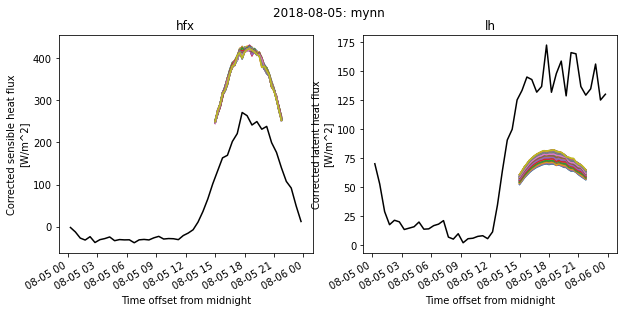

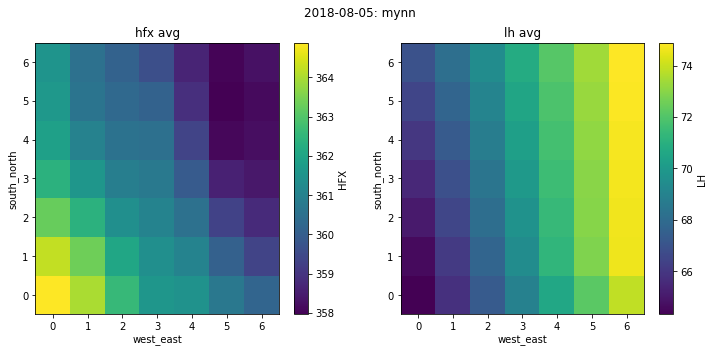

In [148]:
run = 'mynn'
hfx_da_m0805, lh_da_m0805 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_m0805, lh_da_m0805, eval_date)

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:40:00
/projects/mmc/jlee/sg

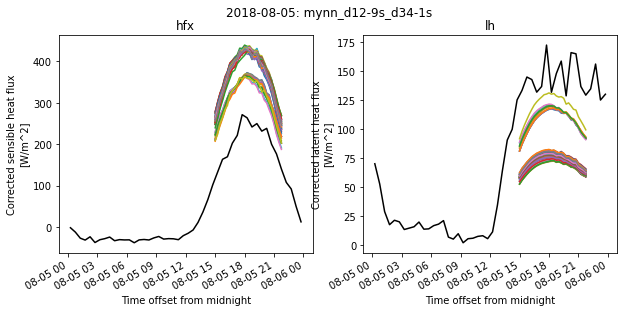

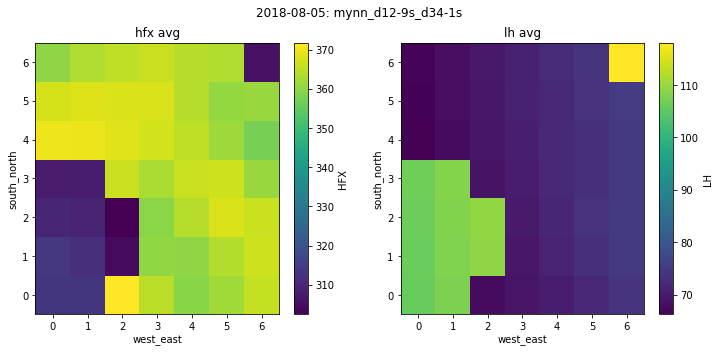

In [147]:
run = 'mynn_d12-9s_d34-1s'
hfx_da_m0805_91, lh_da_m0805_91 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_m0805_91, lh_da_m0805_91, eval_date)

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:40:00
/projects/mmc/jlee/sgp/wrf-mmc/w

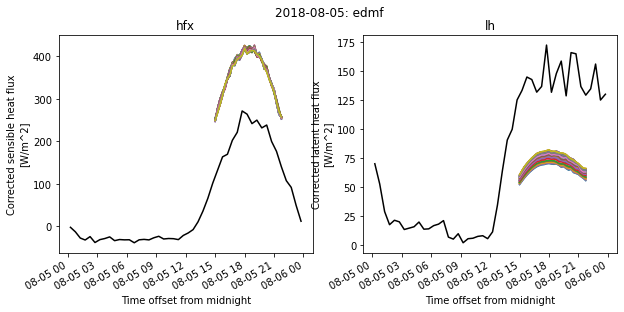

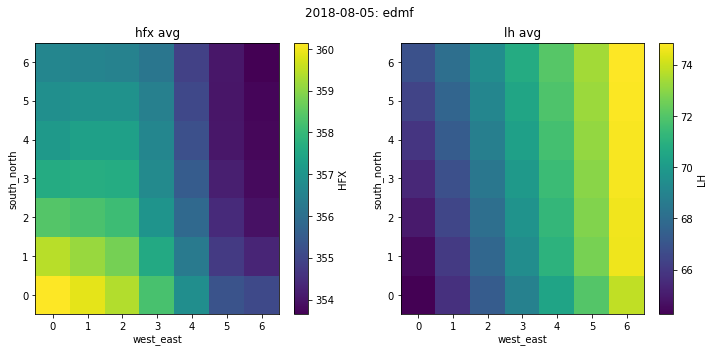

In [149]:
run = 'edmf'
hfx_da_e0805, lh_da_e0805 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_e0805, lh_da_e0805, eval_date)

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/a6_0805e_9s1s/auxout/mmc_d04_2018-08-05_16:40:00
/projects/mmc/jlee/sg

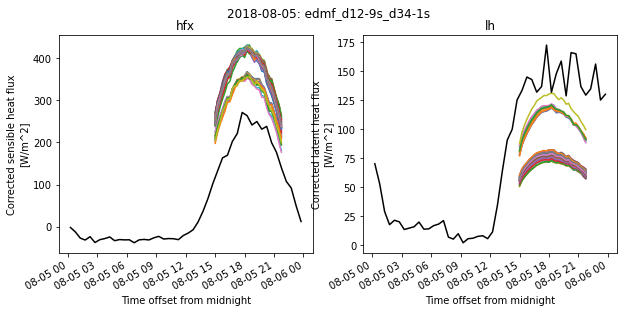

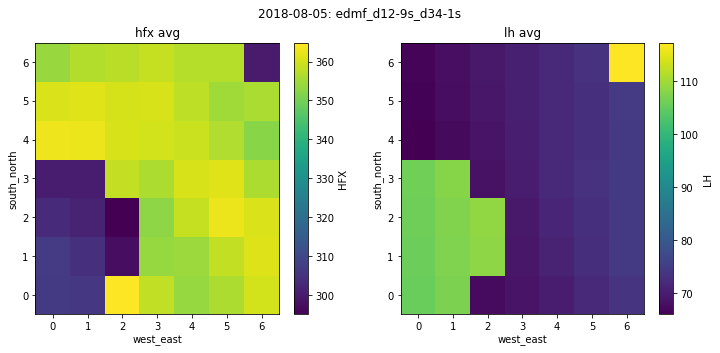

In [150]:
run = 'edmf_d12-9s_d34-1s'
hfx_da_e0805_91, lh_da_e0805_91 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_e0805_91, lh_da_e0805_91, eval_date)

In [153]:
eval_date = '2018-09-01'
neighbor = 3

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:40:00
/projects/mmc/jlee/sgp/wrf-mmc/w

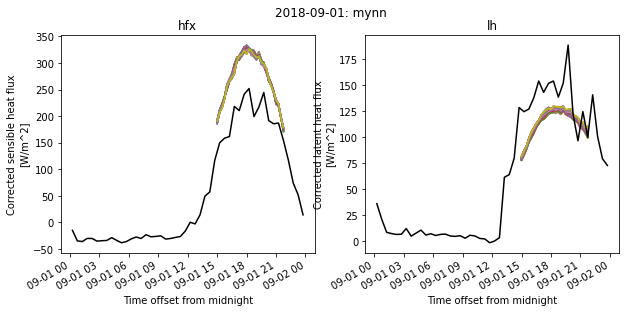

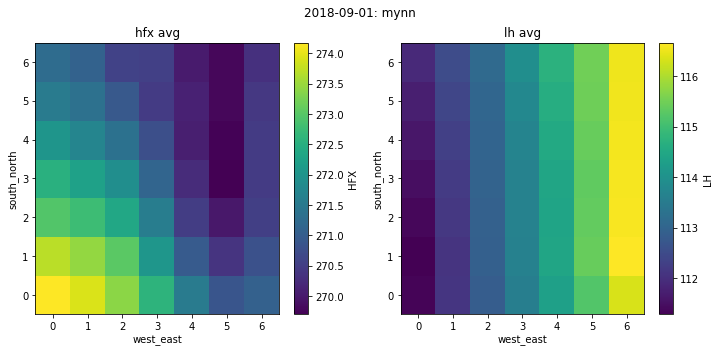

In [156]:
run = 'mynn'
hfx_da_m0901, lh_da_m0901 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_m0901, lh_da_m0901, eval_date)

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o5_0901m_9s1s/auxout/mmc_d04_2018-09-01_16:40:00
/projects/mmc/jlee/sg

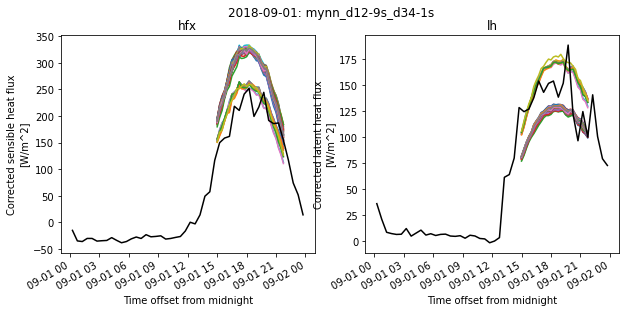

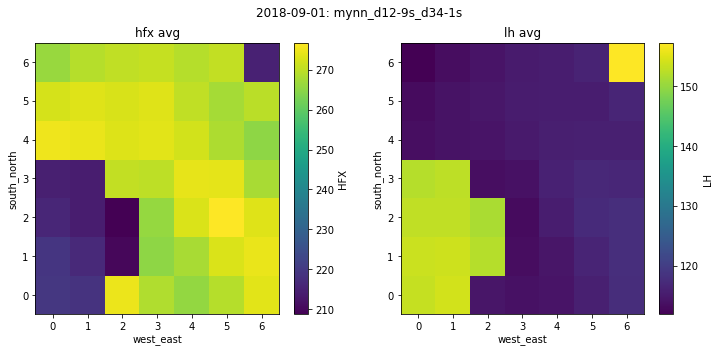

In [157]:
run = 'mynn_d12-9s_d34-1s'
hfx_da_m0901_91, lh_da_m0901_91 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_m0901_91, lh_da_m0901_91, eval_date)

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:40:00
/projects/mmc/jlee/sgp/wrf-mmc/w

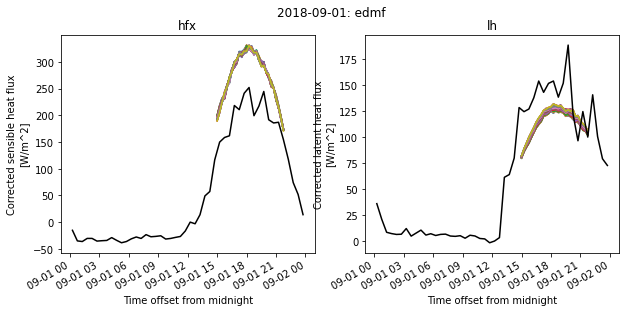

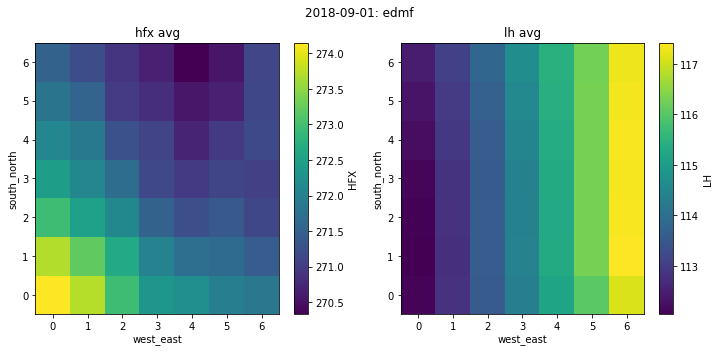

In [154]:
run = 'edmf'
hfx_da_e0901, lh_da_e0901 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_e0901, lh_da_e0901, eval_date)

/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_15:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_15:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_15:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_15:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_15:40:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_15:50:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_16:00:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_16:10:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_16:20:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_16:30:00
/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/o6_0901e_9s1s/auxout/mmc_d04_2018-09-01_16:40:00
/projects/mmc/jlee/sg

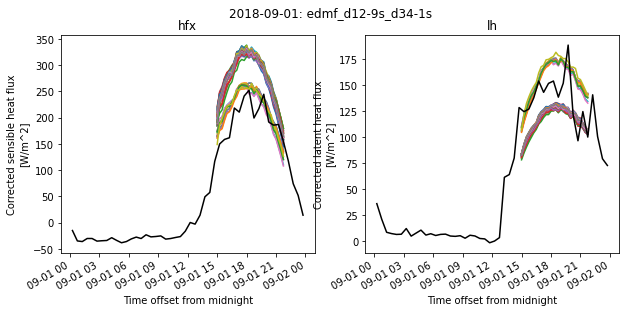

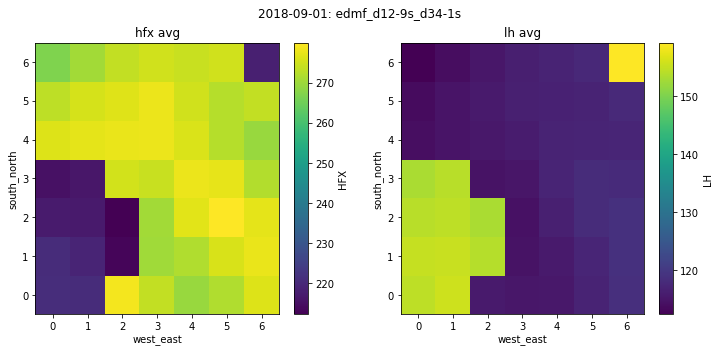

In [155]:
run = 'edmf_d12-9s_d34-1s'
hfx_da_e0901_91, lh_da_e0901_91 = get_neighbor_flux_da(eval_date, run, neighbor)
plot_fluxts_avgheatm(run, hfx_da_e0901_91, lh_da_e0901_91, eval_date)

In [184]:
def plot_total_fluxts_avgheatm(run, hfx_da, lh_da, eval_date):

    co2flx4m_eval = co2flx4m.sel(time=slice(eval_date, eval_date))

    fig, ax = plt.subplots(figsize=(8, 4))

    for i in np.arange(hfx_da.shape[1]):
        for j in np.arange(hfx_da.shape[2]):
            total_da = hfx_da[:, i, j].resample(Time='15Min').asfreq()+lh_da[:, i, j].resample(Time='15Min').asfreq()
            total_da.plot(ax=ax)
    co2flx4m_total = co2flx4m_eval['sensible_heat_flux']+co2flx4m_eval['latent_heat_flux']
    co2flx4m_total.plot(c='k', ax=ax)
    ax.set_title(eval_date+': '+run+' total = sensible + latent')

    plt.suptitle(eval_date+': '+run)
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 5))

    total_mean = hfx_da.mean(dim=['Time'])+lh_da.mean(dim=['Time'])
    total_mean.plot(ax=ax)
    ax.set_title(eval_date+': '+run+' total = sensible + latent')
    plt.show()

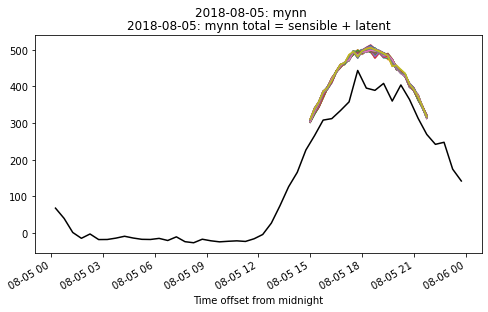

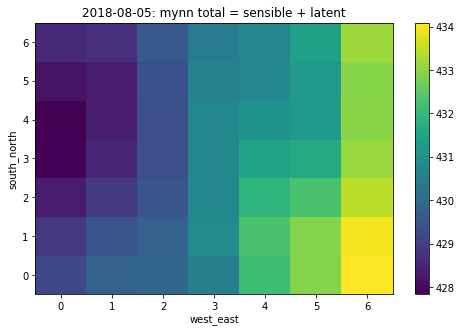

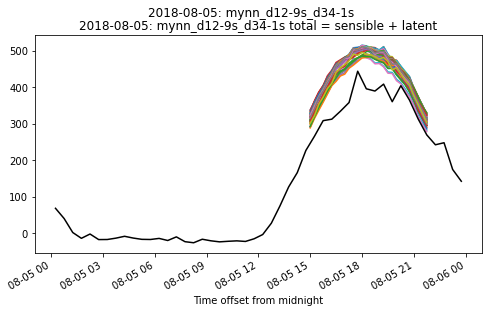

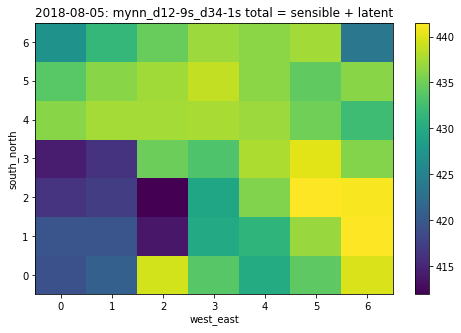

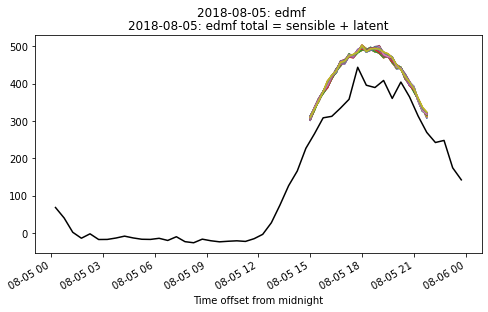

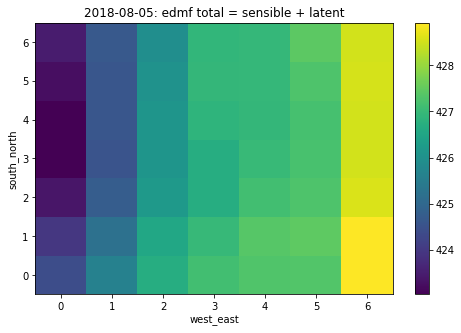

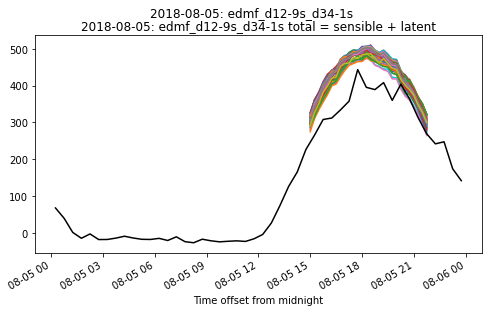

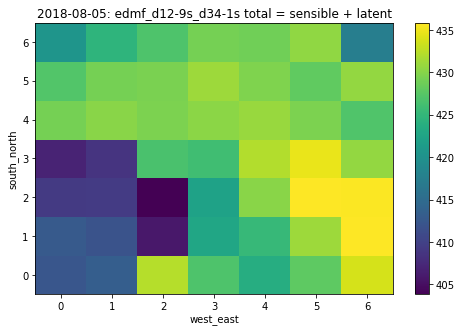

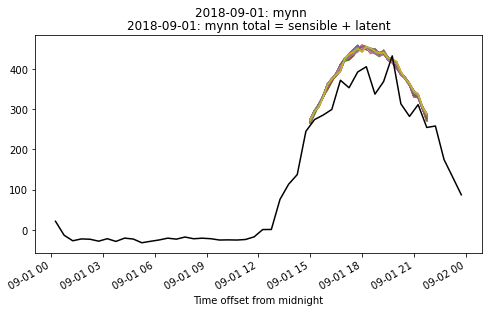

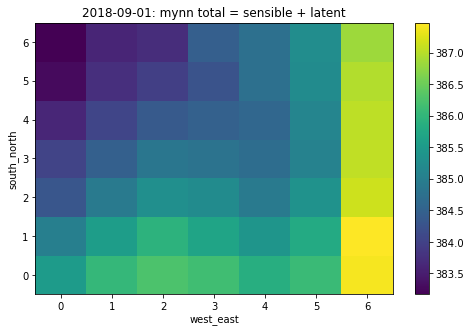

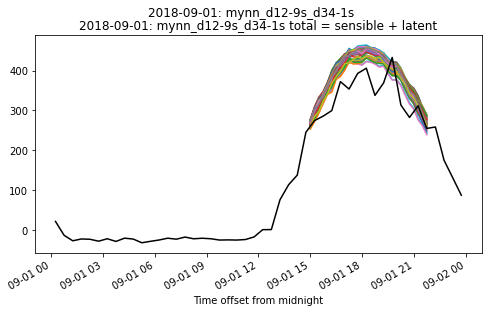

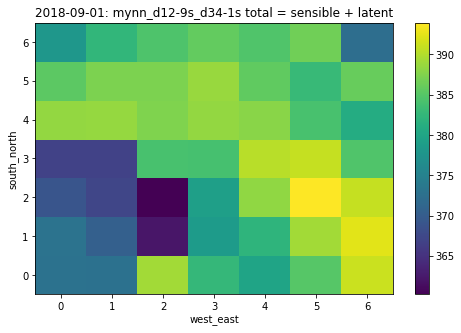

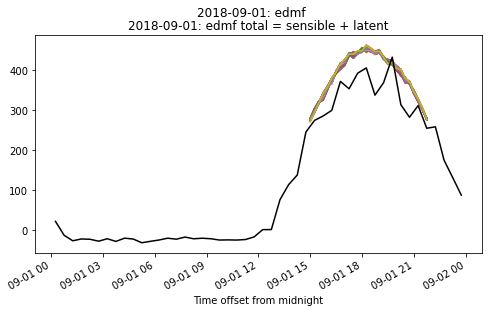

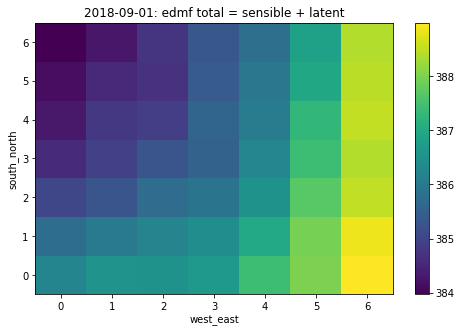

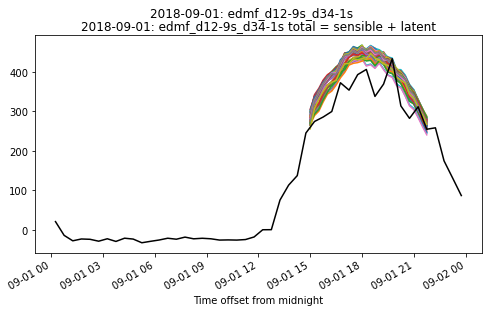

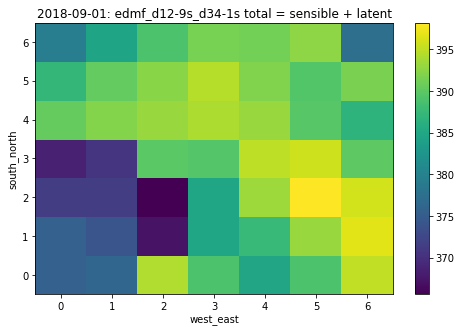

In [185]:
eval_date = '2018-08-05'
plot_total_fluxts_avgheatm('mynn', hfx_da_m0805, lh_da_m0805, eval_date)
plot_total_fluxts_avgheatm('mynn_d12-9s_d34-1s', hfx_da_m0805_91, lh_da_m0805_91, eval_date)
plot_total_fluxts_avgheatm('edmf', hfx_da_e0805, lh_da_e0805, eval_date)
plot_total_fluxts_avgheatm('edmf_d12-9s_d34-1s', hfx_da_e0805_91, lh_da_e0805_91, eval_date)
    
eval_date = '2018-09-01'
plot_total_fluxts_avgheatm('mynn', hfx_da_m0901, lh_da_m0901, eval_date)
plot_total_fluxts_avgheatm('mynn_d12-9s_d34-1s', hfx_da_m0901_91, lh_da_m0901_91, eval_date)
plot_total_fluxts_avgheatm('edmf', hfx_da_e0901, lh_da_e0901, eval_date)
plot_total_fluxts_avgheatm('edmf_d12-9s_d34-1s', hfx_da_e0901_91, lh_da_e0901_91, eval_date)

In [126]:
co2flx4m_eval = co2flx4m.sel(time=slice(eval_date, eval_date))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in np.arange(hfx_da.shape[1]):
    for j in np.arange(hfx_da.shape[2]):
        hfx_da[:, i, j].resample(Time='15Min').asfreq().plot(ax=ax[0])
co2flx4m_eval['sensible_heat_flux'].plot(c='k', ax=ax[0])
ax[0].set_title('hfx')

for i in np.arange(lh_da.shape[1]):
    for j in np.arange(lh_da.shape[2]):
        lh_da[:, i, j].resample(Time='15Min').asfreq().plot(ax=ax[1])
co2flx4m_eval['latent_heat_flux'].plot(c='k', ax=ax[1])
ax[1].set_title('lh')

plt.suptitle(eval_date, '')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

hfx_da.mean(dim=['Time']).plot(ax=ax[0])
ax[0].set_title('hfx avg')

lh_da.mean(dim=['Time']).plot(ax=ax[1])
ax[1].set_title('lh avg')

plt.suptitle(eval_date, '')
plt.show()

In [121]:
hfx_da[:, 0, 0].resample(Time='15Min').asfreq()

<xarray.DataArray 'HFX' (Time: 28)>
array([220.05862, 244.816  , 262.9603 , 277.88132, 295.10876, 308.62738,
       325.21414, 332.51483, 337.82318, 345.22037, 358.88474, 361.4462 ,
       368.73236, 369.25592, 367.4751 , 364.3917 , 357.12073, 353.83853,
       344.01913, 344.7238 , 331.23093, 316.39847, 307.0138 , 289.06473,
       268.0357 , 243.21364, 225.3744 , 208.34319], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2018-08-05T15:00:00 ... 2018-08-05T21:45:00
    XLONG    float32 -97.49
    XLAT     float32 36.6

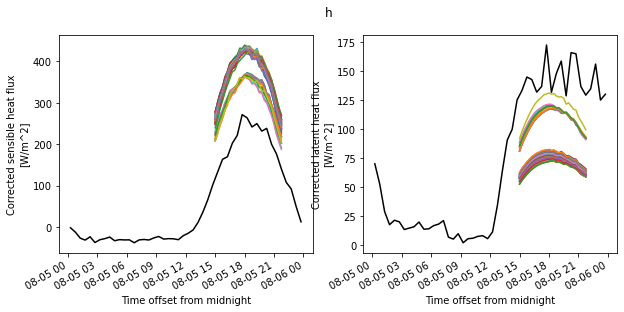

AttributeError: 'QuadMesh' object has no property 'title'

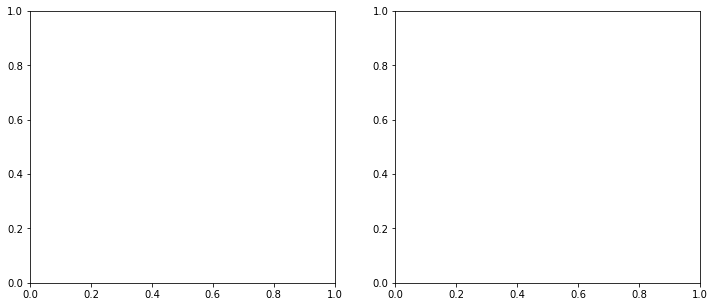

In [141]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in np.arange(hfx_da.shape[1]):
    for j in np.arange(hfx_da.shape[2]):
        hfx_da[:, i, j].resample(Time='15Min').asfreq().plot(ax=ax[0])
co2flx4m_eval['sensible_heat_flux'].plot(c='k', ax=ax[0])
ax[0].set_title('hfx')

for i in np.arange(lh_da.shape[1]):
    for j in np.arange(lh_da.shape[2]):
        lh_da[:, i, j].resample(Time='15Min').asfreq().plot(ax=ax[1])
co2flx4m_eval['latent_heat_flux'].plot(c='k', ax=ax[1])
ax[1].set_title('lh')

plt.suptitle('h')

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

hfx_da.mean(dim=['Time']).plot(ax=ax[0])
ax[0].set_title('hfx avg')

lh_da.mean(dim=['Time']).plot(ax=ax[1])
ax[1].set_title('lh avg')

plt.suptitle('')

plt.show()

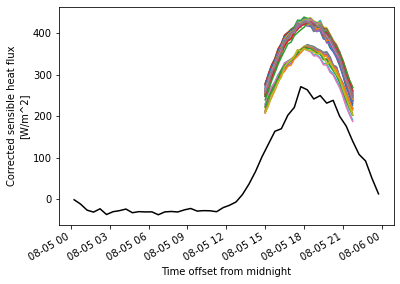

In [128]:
for i in np.arange(hfx_da.shape[1]):
    for j in np.arange(hfx_da.shape[2]):
        hfx_da[:, i, j].resample(Time='15Min').asfreq().plot()
co2flx4m_eval['sensible_heat_flux'].plot(c='k')

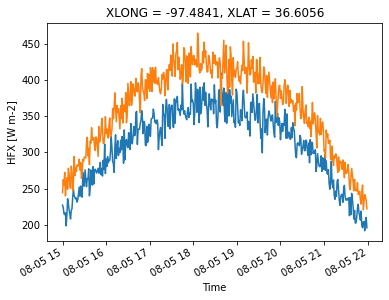

In [99]:
hfx_da[:, 0, 0].plot()
hfx_da[:, -1, -1].plot()
# hfx_da[:, 2, 2].plot()

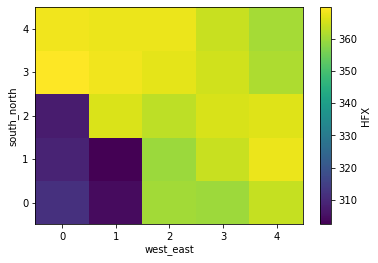

In [95]:
hfx_da.mean(dim=['Time']).plot()

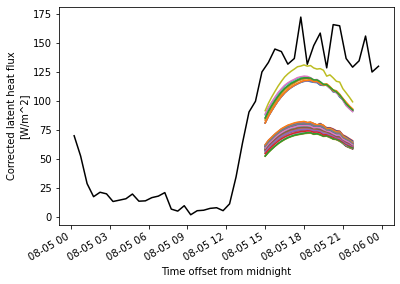

In [129]:
for i in np.arange(lh_da.shape[1]):
    for j in np.arange(lh_da.shape[2]):
        lh_da[:, i, j].resample(Time='15Min').asfreq().plot()
co2flx4m_eval['latent_heat_flux'].plot(c='k')

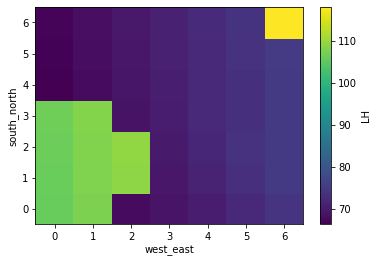

In [130]:
lh_da.mean(dim=['Time']).plot()

In [83]:
site_loc_ij

<xarray.DataArray 'xy' (x_y: 2)>
array([120, 262])
Coordinates:
    latlon_coord  object CoordPair(lat=36.605, lon=-97.485)
  * x_y           (x_y) <U1 'x' 'y'

In [158]:
wrfrstfile = wrf_runs_dir+date_col[run]+'/wrfrst_d04_2018-08-05_16:00:00'
wrfrst = Dataset(wrfrstfile, 'r')
lu_i = wrf.getvar(wrfrst, 'LU_INDEX', timeidx=wrf.ALL_TIMES)

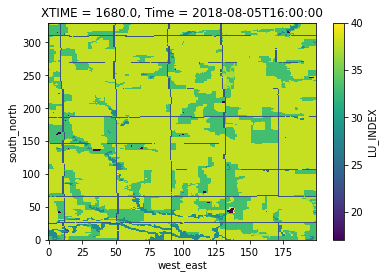

In [159]:
lu_i.plot()

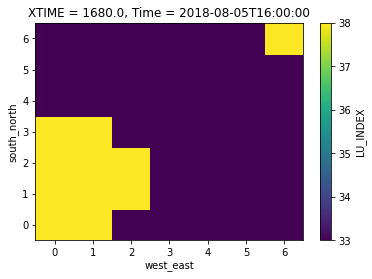

In [160]:
neighbor = 3
lu_i[sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].plot()

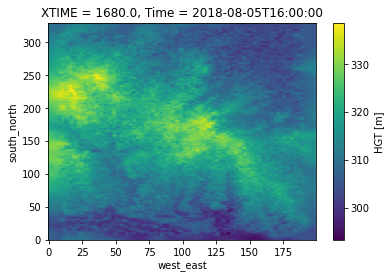

In [161]:
hgt = wrf.getvar(wrfrst, 'HGT', timeidx=wrf.ALL_TIMES)
hgt.plot()

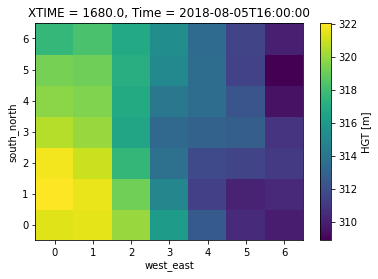

In [162]:
hgt[sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].plot()

In [170]:
wrfrstfiled2 = wrf_runs_dir+date_col[run]+'/wrfrst_d02_2018-08-05_16:00:00'
wrfrstd2 = Dataset(wrfrstfiled2, 'r')
# lu_i = wrf.getvar(wrfrst, 'LU_INDEX', timeidx=wrf.ALL_TIMES)
site_loc_ijd2 = wrf.ll_to_xy(wrfrstd2, site_latitude, site_longitude)
sn_indd2, we_indd2 = site_loc_ijd2.values[1], site_loc_ijd2.values[0]
neighbord2 = 1

In [164]:
site_loc_ijd2

<xarray.DataArray 'xy' (x_y: 2)>
array([121, 124])
Coordinates:
    latlon_coord  object CoordPair(lat=36.605, lon=-97.485)
  * x_y           (x_y) <U1 'x' 'y'

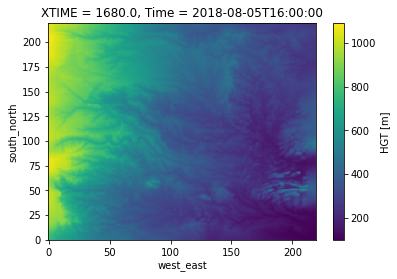

In [166]:
hgt = wrf.getvar(wrfrstd2, 'HGT', timeidx=wrf.ALL_TIMES)
hgt.plot()

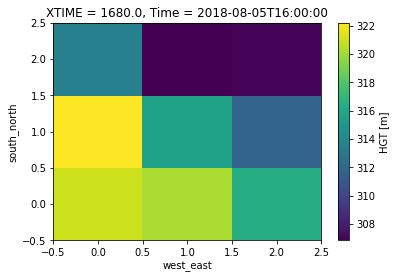

In [171]:
hgt[sn_indd2-neighbord2:sn_indd2+neighbord2+1, we_indd2-neighbord2:we_indd2+neighbord2+1].plot()

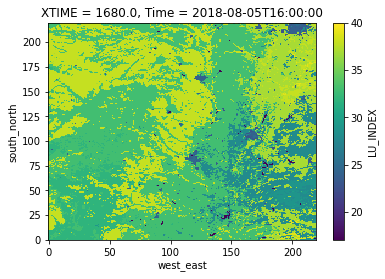

In [172]:
lu_i = wrf.getvar(wrfrstd2, 'LU_INDEX', timeidx=wrf.ALL_TIMES)
lu_i.plot()

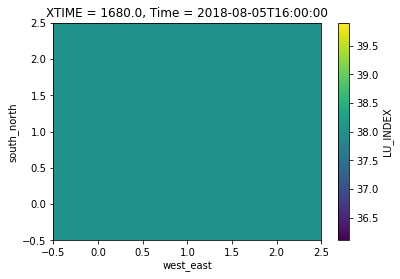

In [175]:
lu_i[sn_indd2-neighbord2:sn_indd2+neighbord2+1, we_indd2-neighbord2:we_indd2+neighbord2+1].plot()

In [176]:
lu_i[sn_indd2-neighbord2:sn_indd2+neighbord2+1, we_indd2-neighbord2:we_indd2+neighbord2+1]

<xarray.DataArray 'LU_INDEX' (south_north: 3, west_east: 3)>
array([[38., 38., 38.],
       [38., 38., 38.],
       [38., 38., 38.]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.52 -97.49 ... -97.49 -97.45
    XLAT     (south_north, west_east) float32 36.57 36.57 36.57 ... 36.62 36.62
    XTIME    float32 1.68e+03
    Time     datetime64[ns] 2018-08-05T16:00:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LAND USE CATEGORY
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [68]:
wrfout

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V4.2.1 MODEL
    START_DATE: 2018-08-05_12:00:00
    SIMULATION_START_DATE: 2018-08-04_12:00:00
    WEST-EAST_GRID_DIMENSION: 201
    SOUTH-NORTH_GRID_DIMENSION: 331
    BOTTOM-TOP_GRID_DIMENSION: 109
    DX: 40.0
    DY: 40.0
    AERCU_OPT: 0
    AERCU_FCT: 1.0
    IDEAL_CASE: 0
    DIFF_6TH_SLOPEOPT: 0
    AUTO_LEVELS_OPT: 2
    DIFF_6TH_THRESH: 0.1
    DZBOT: 50.0
    DZSTRETCH_S: 1.3
    DZSTRETCH_U: 1.1
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 1
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 2
    KM_OPT: 2
    DAMP_OPT: 3
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 28
    RA_LW_PHYSICS: 4
    RA_SW_PHYSICS: 4
    SF_SFCLAY_PHYSICS: 5
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 0
    CU_PHYSICS: 0
    SF_LAKE_PHYSICS: 0
    USE_BATHYMETRY: 0
    SURFACE_INPUT_SOURCE: 3
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
 

In [61]:
wrf.getvar(wrf_single, 'LU', timeidx=wrf.ALL_TIMES)

ValueError: 'LU' is not a valid variable name

In [47]:
hfx_sel

<xarray.DataArray 'HFX' (Time: 10, south_north: 5, west_east: 5)>
array([[[168.71088, 162.4134 , 160.71925, 164.6198 , 169.30786],
        [169.4952 , 161.29636, 157.26602, 162.02988, 167.443  ],
        [170.07831, 161.27885, 154.4979 , 160.32967, 166.54492],
        [169.51367, 161.43616, 152.07094, 159.10797, 166.27512],
        [167.53325, 160.83159, 149.83841, 157.6761 , 166.01028]],

       [[173.27533, 172.3534 , 173.89967, 177.19786, 179.78612],
        [172.60983, 171.70398, 173.23146, 176.90022, 179.6938 ],
        [171.67108, 170.90663, 172.42776, 176.70949, 179.6793 ],
        [170.75299, 169.83295, 171.4848 , 175.99118, 179.46634],
        [169.55183, 168.3297 , 170.10516, 174.5461 , 178.6144 ]],

       [[172.7219 , 174.56944, 175.37555, 175.29408, 175.99408],
        [171.20589, 173.62334, 175.24664, 175.46402, 176.27203],
        [169.8643 , 172.33289, 174.85144, 175.57364, 176.4728 ],
        [168.94875, 170.81639, 173.9391 , 175.38036, 176.37302],
        [168.47961, 169.15154, 172.46483, 174.75201, 176.08603]],

       [[172.30972, 176.8002 , 181.9188 , 184.88165, 184.878  ],
        [171.64035, 174.3362 , 178.70047, 182.58122, 184.17465],
...
        [157.55205, 162.59084, 166.01509, 165.32877, 166.70886]],

       [[172.9571 , 171.84354, 168.15634, 164.80489, 169.7367 ],
        [174.71912, 172.49649, 166.41989, 162.36621, 170.43642],
        [176.57277, 174.41618, 167.54797, 160.98125, 171.00945],
        [178.59576, 177.31313, 170.93242, 161.37544, 170.7909 ],
        [180.57553, 180.53488, 175.33862, 163.38522, 168.33864]],

       [[195.39017, 187.62866, 174.68365, 168.97984, 164.46455],
        [197.03624, 190.40196, 175.8204 , 168.92453, 166.38275],
        [197.81598, 192.57132, 177.66103, 168.84068, 168.37819],
        [197.1505 , 192.74152, 178.35992, 168.86523, 169.73094],
        [194.31062, 190.1135 , 176.90414, 169.03009, 170.6044 ]],

       [[190.77838, 192.04892, 191.99251, 191.57727, 193.10555],
        [190.35817, 191.55083, 191.19885, 190.44237, 191.76659],
        [190.11858, 191.10153, 190.27849, 189.1054 , 189.13521],
        [189.8785 , 190.84142, 189.611  , 187.73027, 185.88383],
        [189.49132, 190.69028, 189.11894, 186.50447, 183.00626]]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XLAT     (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XTIME    (Time) float32 1.57e+03 1.571e+03 1.572e+03 ... 1.578e+03 1.579e+03
  * Time     (Time) datetime64[ns] 2018-08-05T14:10:00 ... 2018-08-05T14:19:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [24]:
hfx[:, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1]

<xarray.DataArray 'HFX' (Time: 10, south_north: 5, west_east: 5)>
array([[[159.82367, 165.0116 , 166.56824, 160.01385, 151.14325],
        [154.30812, 161.46614, 164.45981, 159.4625 , 152.87547],
        [148.17168, 157.5441 , 161.83527, 159.0786 , 155.1823 ],
        [143.68828, 153.90411, 159.7914 , 159.5474 , 157.76279],
        [141.02908, 150.52133, 158.46935, 160.59908, 160.1624 ]],

       [[150.68463, 153.72185, 152.98582, 152.44061, 155.48862],
        [152.22415, 155.57414, 153.45236, 151.05363, 153.77739],
        [153.80724, 157.61475, 154.92863, 150.26457, 151.231  ],
        [155.66013, 159.82831, 157.40991, 150.90149, 148.82292],
        [157.97754, 162.14401, 160.40738, 153.22408, 147.47101]],

       [[147.93947, 146.21777, 154.49586, 158.32463, 160.30101],
        [147.53697, 145.2776 , 153.92741, 158.42877, 160.69435],
        [148.15938, 145.10866, 153.3282 , 158.11269, 161.05989],
        [148.99681, 145.497  , 152.77057, 157.21208, 160.89505],
        [149.43301, 145.91273, 151.9711 , 155.6493 , 159.73798]],

       [[159.90929, 163.285  , 163.32333, 162.80798, 162.16006],
        [158.23871, 163.99716, 163.90997, 162.28593, 160.76428],
...
        [163.40302, 160.74893, 163.26762, 163.79271, 154.72646]],

       [[171.3715 , 163.88704, 156.77643, 165.84332, 173.15736],
        [173.96703, 168.35141, 158.25993, 163.0082 , 172.83998],
        [175.99301, 172.26906, 161.8863 , 159.20483, 171.27342],
        [177.6336 , 175.40628, 166.3463 , 157.38968, 167.40652],
        [178.84048, 177.78008, 170.39842, 158.80202, 162.74677]],

       [[153.5631 , 152.8067 , 162.19838, 167.71448, 169.38426],
        [155.032  , 151.0777 , 160.36136, 167.28595, 169.75519],
        [156.86441, 150.70035, 158.07002, 166.4915 , 169.76582],
        [158.74675, 151.47281, 155.56801, 165.3196 , 169.55714],
        [160.11896, 153.02441, 153.15118, 163.77368, 169.54263]],

       [[160.88826, 151.4694 , 153.95302, 163.4376 , 166.819  ],
        [160.8403 , 152.90758, 152.0608 , 158.76234, 162.20305],
        [159.97916, 154.31844, 151.295  , 156.73317, 159.56645],
        [158.45872, 155.18762, 151.48148, 156.08823, 159.13466],
        [156.8043 , 155.23802, 151.89815, 155.66199, 159.79536]]],
      dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XLAT     (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XTIME    (Time) float32 1.56e+03 1.561e+03 1.562e+03 ... 1.568e+03 1.569e+03
  * Time     (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T14:09:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [18]:
site_loc_ij.values[1]

262

In [16]:
hfx[:, ]

<xarray.DataArray 'HFX' (Time: 10, south_north: 330, west_east: 200)>
array([[[125.34658 , 127.2772  , 127.88366 , ..., 115.6493  ,
         116.70557 , 118.32038 ],
        [125.35733 , 126.5505  , 126.932205, ..., 114.68363 ,
         116.49236 , 118.83693 ],
        [125.416756, 125.11907 , 124.63306 , ..., 115.709145,
         117.28582 , 119.0642  ],
        ...,
        [110.85986 , 108.55138 , 108.12352 , ..., 119.75469 ,
         120.119576, 120.64838 ],
        [111.52463 , 110.22164 , 114.58338 , ..., 117.82271 ,
         120.12363 , 120.11557 ],
        [111.70143 , 110.546455, 114.68345 , ..., 118.17084 ,
         119.78817 , 119.53765 ]],

       [[122.93508 , 125.03577 , 126.08662 , ..., 115.5949  ,
         116.184555, 116.44104 ],
        [123.12686 , 124.69168 , 125.46727 , ..., 115.80797 ,
         116.59569 , 116.90099 ],
        [123.27056 , 124.04114 , 124.11432 , ..., 115.83519 ,
         117.15531 , 117.5343  ],
...
        [127.071   , 128.9717  , 129.25815 , ..., 137.41026 ,
         138.43024 , 139.31023 ],
        [126.28184 , 128.00616 , 128.61195 , ..., 137.03018 ,
         139.07043 , 139.66493 ],
        [125.65277 , 126.716576, 127.7727  , ..., 137.60837 ,
         138.48488 , 138.78116 ]],

       [[138.97032 , 137.89548 , 136.9122  , ..., 140.59087 ,
         141.39624 , 142.38818 ],
        [138.23575 , 136.78322 , 135.73013 , ..., 139.86205 ,
         141.86534 , 142.76537 ],
        [137.5726  , 136.48015 , 135.09209 , ..., 139.40793 ,
         142.34523 , 143.29462 ],
        ...,
        [135.24081 , 135.80254 , 135.04958 , ..., 135.27336 ,
         136.02032 , 137.16463 ],
        [134.71745 , 135.0649  , 134.61319 , ..., 135.21779 ,
         136.73108 , 137.38853 ],
        [134.15967 , 134.55838 , 134.89612 , ..., 135.37091 ,
         136.14432 , 136.2304  ]]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -97.54 -97.54 ... -97.45 -97.45
    XLAT     (south_north, west_east) float32 36.51 36.51 36.51 ... 36.63 36.63
    XTIME    (Time) float32 1.56e+03 1.561e+03 1.562e+03 ... 1.568e+03 1.569e+03
  * Time     (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T14:09:00
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  UPWARD HEAT FLUX AT THE SURFACE
    units:        W m-2
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [12]:
wrf_single = Dataset(file, 'r')

site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)


In [13]:
site_loc_ij

<xarray.DataArray 'xy' (x_y: 2)>
array([120, 262])
Coordinates:
    latlon_coord  object CoordPair(lat=36.605, lon=-97.485)
  * x_y           (x_y) <U1 'x' 'y'

In [ ]:
eval_date = '2018-08-05'
run = 'mynn'
    
dpath = wrf_runs_dir+data_dir_df[eval_date][run]+'/auxout/'

df = pd.DataFrame()

for file in glob.glob(dpath+'mmc_d04*'):

        if '_15:00' not in file: 

            wrf_single = Dataset(file, 'r')

            site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

            wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

            hfx = wrf.getvar(wrf_single, 'HFX', timeidx=wrf.ALL_TIMES)
            lh = wrf.getvar(wrf_single, 'LH', timeidx=wrf.ALL_TIMES)

            if wrf_time.shape[0] > 1:

                hfx_1pt = hfx[:, site_loc_ij.values[1], site_loc_ij.values[0]]
                lh_1pt = lh[:, site_loc_ij.values[1], site_loc_ij.values[0]]

                hfx_cut = hfx[:, cut_cells:-cut_cells, cut_cells:-cut_cells]
                lh_cut = lh[:, cut_cells:-cut_cells, cut_cells:-cut_cells]

                hfx_mean = hfx_cut.mean(dim=['south_north', 'west_east'])
                hfx_std = hfx_cut.std(dim=['south_north', 'west_east'])

                lh_mean = lh_cut.mean(dim=['south_north', 'west_east'])
                lh_std = lh_cut.std(dim=['south_north', 'west_east'])

            else: 

                hfx_1pt = hfx[site_loc_ij.values[1], site_loc_ij.values[0]].values
                lh_1pt = lh[site_loc_ij.values[1], site_loc_ij.values[0]].values

                hfx_cut = hfx[cut_cells:-cut_cells, cut_cells:-cut_cells]
                lh_cut = lh[cut_cells:-cut_cells, cut_cells:-cut_cells]

                hfx_mean = hfx_cut.mean(dim=['south_north', 'west_east']).values
                hfx_std = hfx_cut.std(dim=['south_north', 'west_east']).values

                lh_mean = lh_cut.mean(dim=['south_north', 'west_east']).values
                lh_std = lh_cut.std(dim=['south_north', 'west_east']).values

            df_1file = pd.DataFrame(index=wrf_time, 
                                    data={'hfx_mean': hfx_mean, 'hfx_std': hfx_std, 'hfx_1pt': hfx_1pt, 
                                          'lh_mean': lh_mean, 'lh_std': lh_std, 'lh_1pt': lh_1pt})

            df = df.append(df_1file)

            df.sort_index(inplace=True)

    co2flx25m_ds = co2flx25m.sel(time=slice(df.index.min(), eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(df.index.min(), eval_date))
    ebbre13_ds = ebbre13.sel(time=slice(df.index.min(), eval_date))
    ecore14_ds = ecore14.sel(time=slice(df.index.min(), eval_date))
            
    # resample wrf every 30 minute to match obs frequency
    # obs are 30-minute averages
    df = df.resample('30min').mean()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(df.index, df['hfx_mean'], label='wrf domain mean', c='k', linewidth=1.5)
    ax[0].plot(df.index, df['hfx_1pt'], label='wrf c1', c='k', linewidth=1, linestyle='--')
    ax[0].fill_between(df.index, df['hfx_mean']+df['hfx_std'], df['hfx_mean']-df['hfx_std'], color='k',
                       alpha=0.1, label='wrf mean + std')

    ax[1].plot(df.index, df['lh_mean'], label='wrf domain mean', c='k', linewidth=1.5)
    ax[1].plot(df.index, df['lh_1pt'], label='wrf c1', c='k', linewidth=1, linestyle='--')
    ax[1].fill_between(df.index, df['lh_mean']+df['lh_std'], df['lh_mean']-df['lh_std'], color='k',
                       alpha=0.1, label='wrf mean + std')
    
    ax[0].set_ylim(0, 440)
    ax[1].set_ylim(0, 440)

    # co2flx25m_ds

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        co2flx4m_ds[var[1][0]] = co2flx4m[var[1][0]].where(co2flx4m['qc_'+var[1][0]] <= 3)
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

    for var, ax_i in zip(ebbre13_dict.items(), ax): 

        ebbre13_ds[var[1][0]] = ebbre13[var[1][0]].where(ebbre13['qc_'+var[1][0]] == 0)
        ax_i.plot(ebbre13_ds['time'], -ebbre13_ds[var[1][0]], label='ebbre13')

    for var, ax_i in zip(ecore14_dict.items(), ax): 

        ecore14_ds[var[1][0]] = ecore14[var[1][0]].where(ecore14['qc_'+var[1][0]] == 0)
        ax_i.plot(ecore14_ds['time'], ecore14_ds[var[1][0]], label='ecore14')

    for wrf_var, var in co2flx25m_dict.items(): 

        co2flx25m_ds[var[0]] = co2flx25m[var[0]].where(co2flx25m['qc_'+var[0]] <= 3)
        ax[0].plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.set_title(var[1][0]+': '+run+'\n'+' vs obs: '+eval_date+'\nwrf mean std = '
                       +str(np.round(df[var[0]+'_std'].mean(), 3))+r' W m$^{-2}$')
        ax_i.set_ylabel(var[1][1])
    #     ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)

    #     ax_i.legend()
        handles, labels = ax_i.get_legend_handles_labels()
    #     print(labels)
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax_i.legend(handles, labels)

    ax[0].tick_params(labelrotation=90)
    ax[1].tick_params(labelrotation=90)
    
#     plt.savefig(plots_dir+'/'+eval_date+'_2areaflux_'+run+'.pdf')

    plt.show()